# Tutorial: How to build a Problem in PINA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial16/tutorial.ipynb)


In this tutorial, we will demonstrate how to build a **Problem** in **PINA** using a toy example. The tutorial will cover the following topics:

- **Building a Problem**: Learn how to construct a problem using the built-in PINA classes.
- **Generating Data for Physics-Informed Training**: Understand how to generate the necessary data for training.
- **Exploring the `problem.zoo` Module**: Get familiar with the `problem.zoo` module, which collects pre-built problems for easy use.

By the end of this tutorial, you'll be able to write **data-driven** or **differential problems** in **PINA** and prepare them for model training!

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import warnings
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Build a PINA problem

In **PINA**, defining a problem is done by creating a Python `class` that inherits from one or more problem classes, such as `SpatialProblem`, `TimeDependentProblem`, or `ParametricProblem`, depending on the nature of the problem. We refer to the `model` as the object that solves the problem, e.g., a **Neural Network**.

We can have two types of problems:
1. ***Data-Driven Problems***: The model is trained using data, such as in classification networks or autoencoders.
2. ***Physics-Driven Problems***: The model is trained using physical laws representing the problem, such as in **PINNs**.
Let's start by building the first type, the data driven type. 

### Data driven modelling
In data-driven modelling, we always have an **input** and a **target**. The model's objective is to reconstruct the target from the input. Examples include:
- Image reconstruction (perturbed image as input, clear image as target)
- Classification (e.g., input: molecule, target: chemical properties)

To build a data-driven problem in **PINA**, you can inherit from the `AbstractProblem` class. Below is an example of a regression problem where the input is a scalar value `x` and the target is a scalar value `y`.

```python
from pina.problem import AbstractProblem

class SupervisedProblem(AbstractProblem):
    
    input_variables = ['x']
    output_variables = ['y']

    # other stuff ...
```
Observe that we define `input_variables` and `output_variables` as lists of symbols. This is because, in PINA, `torch.Tensors` can be labeled (see [`LabelTensor`](https://mathlab.github.io/PINA/_rst/label_tensor.html)), providing maximum flexibility for tensor manipulation. If you prefer to use regular tensors, you can simply set these to ``None``.

To specify the input and target data, you need to use the [`Condition`](https://mathlab.github.io/PINA/_rst/condition/condition.html) interface. A condition defines the constraints (such as physical equations, boundary conditions, etc.) that must be satisfied within the problem. Once the condition is applied, the full problem is outlined below:

In [2]:
from pina import Condition, LabelTensor
from pina.problem import AbstractProblem

# creating some fictitious data
input_1 = LabelTensor(torch.randn(10, 1), "x")  # <== input_variables
input_2 = LabelTensor(torch.randn(10, 1), "x")  # <== input_variables
target_1 = LabelTensor(torch.randn(10, 1), "y")  # <== output_variables
target_2 = LabelTensor(torch.randn(10, 1), "y")  # <== output_variables


class SupervisedProblem(AbstractProblem):

    input_variables = ["x"]
    output_variables = ["y"]

    conditions = {
        "condition_1": Condition(input=input_1, target=target_1),
        "condition_2": Condition(input=input_2, target=target_2),
    }


problem = SupervisedProblem()

You can define as many conditions as needed, and the model will attempt to minimize all of them simultaneously! You can access the data in various ways:

- `problem.conditions['<condition name>'].input`, `problem.conditions['<condition name>'].target` – Access the input and output data for the specified condition `<condition name>`.
- `problem.input_pts` – Access the input points for all conditions.

To ensure that the problem is ready, you can check if all domains have been discretized, meaning all conditions have input points available to pass to the model:

In [3]:
# check if all domains are discretised
problem.are_all_domains_discretised

True

>👉 **You can use multiple data structures in PINA conditions, including `Graph` or `Data` from `PyG`. To explore the different data structures available in PINA, check out [this tutorial](), and for more information on input-target conditions, visit the conditions factory classes [here](https://mathlab.github.io/PINA/_rst/condition/input_target_condition.html)**.

### Simple Ordinary Differential Equation
What if we don't have data but we know the physical laws that define the data? Then physics-informed training is the solution! As an example, consider the following Ordinary Differential Equation (ODE):

$$
\begin{equation}
\begin{cases}
\frac{d}{dx}u(x) &=  u(x) \quad x\in(0,1)\\
u(x=0) &= 1 \\
\end{cases}
\end{equation}
$$

with the analytical solution $u(x) = e^x$. This problem is a spatial problem because the ODE depends only on the spatial variable $x\in(0,1)$. In PINA, differential problems are categorized by their nature, e.g.:
* `SpatialProblem` $\rightarrow$ a differential equation with spatial variable(s)
* `TimeDependentProblem` $\rightarrow$ a time-dependent differential equation with temporal variable(s)
* `ParametricProblem` $\rightarrow$ a parametrized differential equation with parametric variable(s)
* `InverseProblem` $\rightarrow$ this is a more advanced topic, see [this tutorial](https://mathlab.github.io/PINA/tutorial7/tutorial.html) for more details.

In our case, the physical ODE inherits from the `SpatialProblem` class, since only spatial variables define the ODE.

```python
class SimpleODE(SpatialProblem):
    
    output_variables = ['u']
    spatial_domain = CartesianDomain{'x': [0, 1]})

    # other stuff ...
```

What if our equation is was also time-dependent, e.g. Partial Differential Equations (PDE)? In this case, our `class` will inherit from both `SpatialProblem` and `TimeDependentProblem`:


```python
class TimeSpaceODE(SpatialProblem, TimeDependentProblem):

    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})

    # other stuff ...
```

Differently from data-driven problems, differential-problems need to specify the domain type. If you look at our ODE definition, the spatial varibale $x$ is defined in the interval $(0,1)$, and accordingly the `spatial_domain` is a `CartesianDomain` with the input variable `x` in `[0,1]`. To know more about the Domain class see the [related tutorial](https://mathlab.github.io/PINA/tutorial6/tutorial.html). Different problems require different domain, here below we summarize the relevant ones:

| Problem Type            | Required Domain                |
|-------------------------|--------------------------------|
| `SpatialProblem`        | `spatial_domain`              |
| `TimeDependentProblem`  | `temporal_domain`             |
| `ParametricProblem`     | `parameter_domain`            |
| `InverseProblem`        | `unknown_parameter_domain`    |

Nice, the Problem class is initialized! How to represent the differential equation in **PINA**? To do this, we need to load the **PINA** operators from `pina.operator` module. Again, we'll consider Equation (1) and represent it in **PINA**:

In [4]:
from pina.problem import SpatialProblem
from pina.operator import grad
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue


# defining the ode equation
def ode_equation(input_, output_):

    # computing the derivative
    u_x = grad(output_, input_, components=["u"], d=["x"])

    # extracting the u input variable
    u = output_.extract(["u"])

    # calculate the residual and return it
    return u_x - u


class SimpleODE(SpatialProblem):

    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1]})

    domains = {
        "x0": CartesianDomain({"x": 0.0}),
        "D": spatial_domain,
    }

    # conditions to hold
    conditions = {
        "bound_cond": Condition(domain="x0", equation=FixedValue(1.0)),
        "phys_cond": Condition(domain="D", equation=Equation(ode_equation)),
    }

    # defining the true solution
    def solution(self, pts):
        return torch.exp(pts.extract(["x"]))

As you can see, we implemented the `ode_equation` function which given the model ouput and input returns the equation residual. These residuals are the ones minimized during PINN optimization (for more on PINN see [the related tutorials](https://mathlab.github.io/PINA/_tutorial.html#physics-informed-neural-networks)). 

How are the residuals computed?
Given the output we perform differential operation using the [operator modulus](https://mathlab.github.io/PINA/_rst/operator.html). It is pretty intuitive, each differential operator takes the following inputs: 
- A tensor on which the operator is applied. 
- A tensor with respect to which the operator is computed. 
- The names of the output variables for which the operator is evaluated. 
- The names of the variables with respect to which the operator is computed.
We also have a `fast` version of differential operators, where no checks are performed. This can be used to boost performances, once you know the standard ones are doing their job. 

Notice that we do not pass directly a `python` function, but an `Equation` object, which is initialized with the `python` function. This is done so that all the computations and internal checks are done inside **PINA**, see [the related tutorials](https://mathlab.github.io/PINA/tutorial12/tutorial.html) for more.

Once we have defined the function, we need to tell the neural network where these methods are to be applied. To do so, we use again the `Condition` class. In the `Condition` class, we pass the location points and the equation we want minimized on those points.

Finally, it's possible to define a `solution` function, which can be useful if we want to plot the results and see how the real solution compares to the expected (true) solution. Notice that the `solution` function is a method of the `Problem` class, but it is not mandatory for problem definition.


## Generate data for Physical Problems

When training physics based models, data can come in form of direct numerical simulation results (tensors, graph), or points in the domains which need to be sampled. In case we perform unsupervised learning, we just need the collocation points for training, i.e. points where we want to evaluate the neural network. Sampling point in **PINA** is very easy. But first, let's check if the domains are dicsretized by using the `are_all_domains_discretised` method.

In [5]:
problem = SimpleODE()
problem.are_all_domains_discretised

False

This is false becase the input points are not available (we need to discretize!). If you call `problem.input_points` at this stage you will get an error due to point missing in the condition.

```bash
>>> problem.input_pts
```
```python
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[32], line 1
----> 1 problem.input_pts

File ~/GitHub/PINA/pina/problem/abstract_problem.py:78, in AbstractProblem.input_pts(self)
     76         to_return[cond_name] = cond.input
     77     elif hasattr(cond, "domain"):
---> 78         to_return[cond_name] = self._discretised_domains[cond.domain]
     79 return to_return

KeyError: 'x0'
```

To discretise the problem you can use the `discretise_domain` method:

In [6]:
# sampling 20 points in [0, 1] through discretization in all locations
problem.discretise_domain(n=20, mode="grid", domains="all")

# sampling 20 points in (0, 1) through latin hypercube sampling in D, and 1 point in x0
problem.discretise_domain(n=20, mode="latin", domains=["D"])
problem.discretise_domain(n=1, mode="random", domains=["x0"])

# sampling 20 points in (0, 1) randomly
problem.discretise_domain(n=20, mode="random")

We are going to use latin hypercube points for sampling. We need to sample in all the conditions domains. In our case we sample in `D` and `x0`.

In [7]:
# sampling for training
problem.discretise_domain(1, "random", domains=["x0"])
problem.discretise_domain(5, "lh", domains=["D"])

The points are saved in a python `dict`, and can be accessed by calling the attributes `input_pts` or `discretised_domains` of the problem.

In [8]:
print("Input points:", problem.input_pts)
print("Input points labels:", problem.discretised_domains)

Input points: {'bound_cond': LabelTensor([[0.]]), 'phys_cond': LabelTensor([[0.3963],
             [0.4620],
             [0.8240],
             [0.7956],
             [0.1866]])}
Input points labels: {'x0': LabelTensor([[0.]]), 'D': LabelTensor([[0.3963],
             [0.4620],
             [0.8240],
             [0.7956],
             [0.1866]])}


To visualize the sampled points we can use `matplotlib.pyplot`:

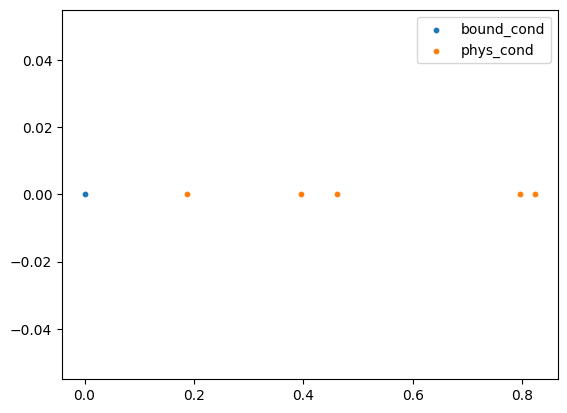

In [9]:
for location in problem.input_pts:
    coords = (
        problem.input_pts[location].extract(problem.spatial_variables).flatten()
    )
    plt.scatter(coords, torch.zeros_like(coords), s=10, label=location)
plt.legend()

## The Problem Zoo module

In PINA many problems are already implemented for you in the [Problem Zoo module](https://mathlab.github.io/PINA/_rst/_code.html#problems-zoo). For example, the supervised problem at the beginning of the tutorial is implemented in [`SupervisedProblem`](https://mathlab.github.io/PINA/_rst/problem/zoo/supervised_problem.html)!

Let's see now a physics based example, the advection equation

In [10]:
from pina.problem.zoo import AdvectionProblem

# defining the problem
problem = AdvectionProblem()

# some infos
print(
    f"The {problem.__class__.__name__} has {len(problem.conditions)} "
    f"conditions with names {list(problem.conditions.keys())} \n"
    "The problem inherits from "
    f"{[cls.__name__ for cls in problem.__class__.__bases__]} \n"
    f"and the domains are of type {type(problem.domains['t0']).__name__}"
)

The AdvectionProblem has 2 conditions with names ['t0', 'D'] 
The problem inherits from ['SpatialProblem', 'TimeDependentProblem'] 
and the domains are of type CartesianDomain


## What's Next?

Congratulations on completing the introductory tutorial of **PINA** problems! There are several directions you can explore next:

1. **Create Custom Problems**: Try building your own problems using the PINA framework, experiment with different PDEs, initial/boundary conditions, and data structures.

2. **Explore the Problem Zoo**: Dive into the [`problem.zoo` module](https://mathlab.github.io/PINA/_rst/_code.html#problems-zoo) to find a variety of predefined problem setups and use them as a starting point or inspiration for your own.

3. **...and many more!**: The possibilities are vast! Consider experimenting with different solver strategies, model architectures, or even implementing your own physical constraints.

For more examples and in-depth guides, be sure to check out the [PINA Documentation](https://mathlab.github.io/PINA/).